## Project Problem Description
Given a dataset for doordash from the year 2015, we are asked to predict the delivery duration. It is imperative for the business to provide timely service and is cornerstone for customer satisfaction. In this assignment, we will build prediction models to estimate the time it takes for delivering. 

### Data Exploration 
As explained in the problem description, this is a regression task. We first start with data exploration and then continue with investigating features for data preprocessing. Finally, we move to modelling. During this part, we examine the performance of different models. 


Now start by loading the dataset from the datasets folder. Inorder to do this, import the relevant libraries for both data exploration and data visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# set random seeds to have reproducible results, also helps in comparing model performances(performance not based on random chance) and 
# could help in debugging
# sklearn uses numpy random seed
np.random.seed(42)


Read data from the given file (historical_data.csv)

In [3]:
historical_data = pd.read_csv("../datasets/historical_data.csv")
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


Check the column data types and non-null count using the dataframe.info() function

In [4]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

Some id columns in the Dataframe are not useful for modelling. The dataset also includes null values which will be dealt with in the data preprocessing stage.

More importantly, there is no target column corresponding to what we are trying to predict. So we feature engineer a new variable which will be the target column. This column named `total_delivery_time` would be the difference between `actual_delivery_time` and `created_at`. To do this, we first convert the relevant columns to the DateTime type. Later, we obtain the time in seconds through functions defined in the DateTime class.

In [5]:
from datetime import datetime 
historical_data['created_at'] = pd.to_datetime(historical_data['created_at']) 
historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time']) 
historical_data['total_delivery_time'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


total_delivery_time can be separated to preparation time and non-preparation time where preparation time is the time needed to prepare the food. Non-preparation time would be everything aside from that. This would include things like time taken for the restaurant to get the order and the time it takes for the delivery to reach the destination. We have corresponding variables named `estimated_order_place_duration` and `estimated_store_to_consumer_driving_duration` for non-preparation duration. So create a new variable named `estimated_non_prep_duration` which will be the sum of these two columns

In [6]:
historical_data['estimated_non_prep_duration'] = historical_data['estimated_order_place_duration'] + historical_data['estimated_store_to_consumer_driving_duration']
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,estimated_non_prep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0


At any given order, there are dashers who are either taking another order or are currently available to take an order. Since we have columns corresponding to onshift dashers and busy dashers, we can compute the busy dashers ratio. 

In [7]:
historical_data['busy_dashers_ratio'] = historical_data['total_busy_dashers'] / historical_data['total_onshift_dashers']

In [8]:
historical_data[historical_data['busy_dashers_ratio'] <= 1].shape
##historical_data[historical_data['busy_dashers_ratio'] > 1]

(137217, 19)

It seems there are over 40000 observations with busy_dashers_ratio over 1, which is surprising. According to the dataset documentation provided, `total_busy_dasher` should be a subset of `total_onshift_dasher`, i.e the ratio cannot be more than 1. But for the sake of the project, we assume there were inconsistencies in how the data was logged. For example: onshift and busy dashers data not in sync. For now, we move on but if this is a major problem, we come back to it again. 

We now look at the categorical columns especially the ids columns. We have `market_id` and `store_id` columns. These columns can be hot encoded to the dataframe and original columns can be dropped. However, we want to check if hot encoding makes sense for these columns. 

In [9]:
historical_data['market_id'].nunique() # gives the number of unique categories the column takes on

6

In [10]:
historical_data['store_id'].nunique()

6743

There are 6 different categories `market_id` takes on and 6743 different categories `store_id` takes on. One-hot encoding the `market_id` is possible while encoding `store_id` would be cumbersome and have more net negatives like a larger dataset so we completely delete this column from the dataset. Another categorical column which is not an id is the `order_protocol` column. This column could have an effect on the delivery time so keep this column. First we check if the column could be hot-encoded. 

In [11]:
historical_data['order_protocol'].nunique()

7

Another categorical variable is `store_primary_category`. This column includes some null values. We impute the null values with the mode the corresponding store's primary category. 

In [12]:
store_id_unique = historical_data['store_id'].unique().tolist()
store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() for store_id in store_id_unique}

In [13]:
def fill(store_id):
    '''Return primary store category from the dictionary'''
    try:
        return store_id_and_category[store_id].values[0] #the .values[0] converts the first item(a store can have multiple mode categories) in the panda series to a native python value usually a string
    except:
        return np.nan
    
# fill the null values from the `store_primary_category` with the values from the dictionary
historical_data['nan_free_store_primary_category'] = historical_data.store_id.apply(fill)

In [14]:
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,estimated_non_prep_duration,busy_dashers_ratio,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian


The nan values in rows 2,3 and 4 are gone and replaced by the mode of the store's primary category. But, see for the second observation that the store's primary cateogory in the given column is listed as Mexican but the column we created tags it as Indian. The associated store id is 5477. 

In [15]:
store_id_and_category[5477]

0     indian
1    mexican
Name: store_primary_category, dtype: object

The dictionary we use to store the mode category for store id suggests that store with store id 5477 has equal numbers of Mexican and Indian categories. On the implementation to choose one mode, we take the first item on the list. 

In [16]:
num_of_mexican_category=historical_data[(historical_data.store_id == 5477) & (historical_data.store_primary_category =='mexican')]
num_of_indian_category=historical_data[(historical_data.store_id == 5477) & (historical_data.store_primary_category =='indian')]
print("Number of rows with the primary category listed as Indian: "+str(num_of_indian_category.shape[0]))
print("Number of rows with the primary category listed as Mexican: "+str(num_of_mexican_category.shape[0]))

Number of rows with the primary category listed as Indian: 1
Number of rows with the primary category listed as Mexican: 1


Mexican and Indian are categories which both appear only once for all the observations from store 5477. The type of cuisine could probably cause changes in the preparation time, so we do not drop this column. We will apply one-hot encoding to this column along with other categorical variables too. We achieve this by using pandas.get_dummies().

In [17]:
# create dummies for order_protocol
order_protocol_dummies = pd.get_dummies(historical_data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,True,False,False,False,False,False,False
1,False,True,False,False,False,False,False
2,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [18]:
# create dummies for market_id
market_id_dummies = pd.get_dummies(historical_data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,True,False,False,False,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,False,True,False,False,False


In [19]:
# create dummies for store primary category
store_primary_category_dummies = pd.get_dummies(historical_data.store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Original columns are not used but the transformed version of these columns will be used for the predictive models. Also, among the categorical variables, only those variables which might impact delivery duration will be used for the prediction, rest of the columns are dropped.

In [20]:
# drop unneccesary columns 
train_df = historical_data.drop(columns = ['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time', 'nan_free_store_primary_category', 'order_protocol'])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,estimated_non_prep_duration,busy_dashers_ratio
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000


Finally, concatenate all the columns to form our final version of our dataframe. Now that we have all numerical values, we convert the whole dataframe to float for the machine learning models to use.

In [21]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
# align dtype over dataset
train_df = train_df.astype('float32')
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A final check on our dataset

In [22]:
train_df.describe()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000790,0.000187,0.005531,0.011077,0.000740,0.036596,0.001200,0.001413,0.004280,0.030872
std,2.666546,1823.093750,1.630255,522.038635,558.411377,34.526787,32.145733,52.661831,90.139648,219.352905,...,0.028099,0.013689,0.074166,0.104665,0.027184,0.187767,0.034627,0.037566,0.065282,0.172971
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
train_df['busy_dashers_ratio'].describe()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

There is a high max-min difference and some infinity values. We need to replace all the infinity values with nan to drop since they are not useful in the prediction.

In [24]:
# check infinity values with using numpy isfinite() function
np.where(np.any(~np.isfinite(train_df), axis=0) == True)

# np.isfinite() is used to also flag any corrupted values like infinity and nan. If np.isinf() would have been used, we would have only flagged infinite values whether positive or negative.

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [25]:
# replace the inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all nans
train_df.dropna(inplace = True)
train_df.shape


(177070, 100)

In [26]:
train_df.isna().sum().sum()

0

We are now certain that our final dataframe does not contain any undefined values like nan, inf, -inf which would corrupt statistical summaries. 

### Remove Redundant and Collinear Features
We have 100 columns in our final dataset and there is a possibility that there are columns correlated to each other or redundant. The redundant features are not useful in any way and does not add any key knowledge. Conversely, collinear features are associated to each other and may bias the model by placing extra weightage to the variables. We start with the correlation matrix

<Axes: >

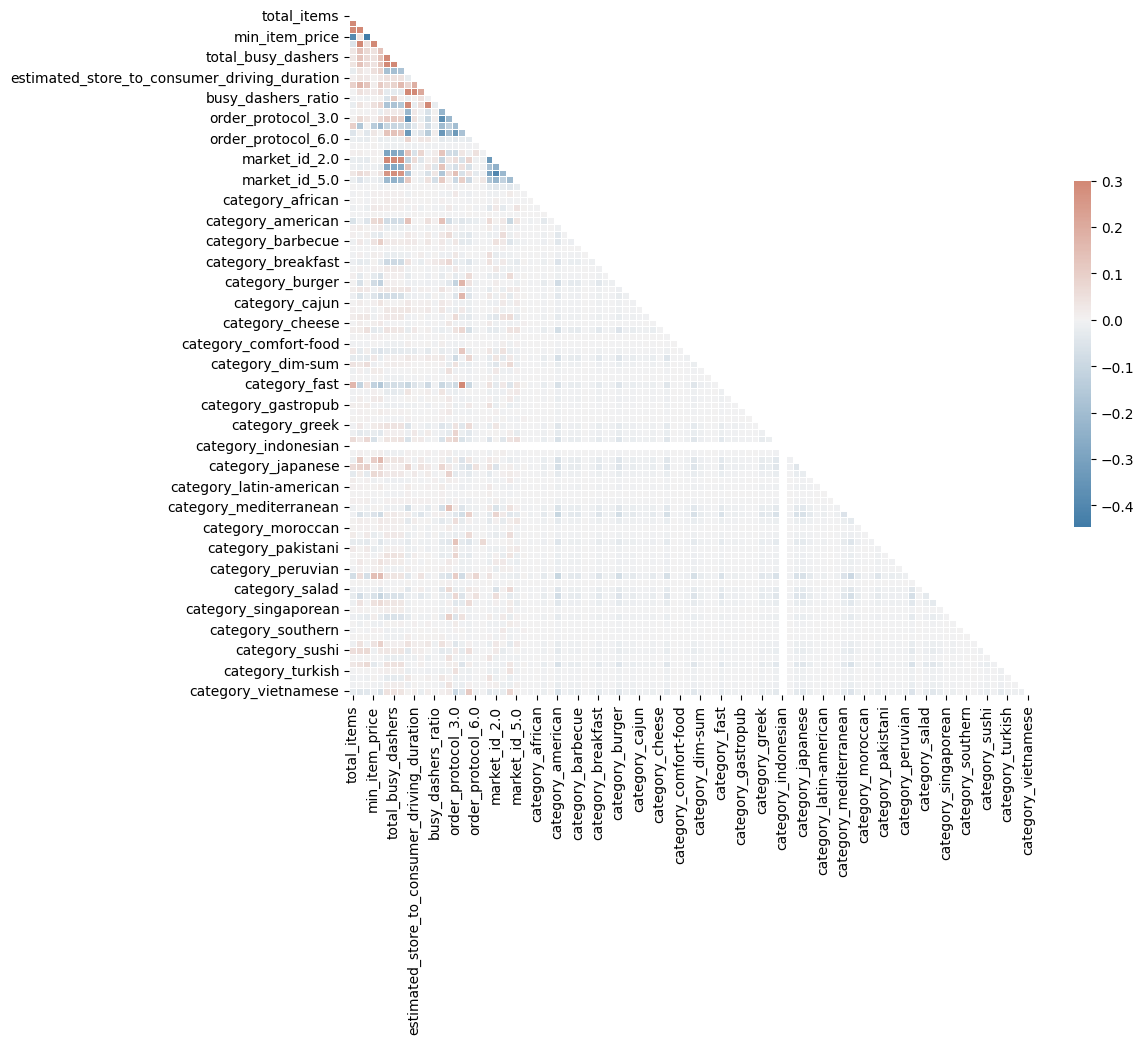

In [27]:
# it could take somme time to run  his cell since we are calculating correlation matrix in a dimension of 100*100
# To get a better illustration, we will take only one triangle because the other triangle is symmetrical to it

# Generate a mask for the upper triangle
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

# setup the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(240, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})

Seems like there is a problem with `category_indonesian`. Check with *.describe()*

In [28]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

It seems that when filtering for the NaN values with the `busy_dasher_ratio` above, we may have removed all instances of the store's primary category being Indonesian therefore there is no variance in this column. And because there is no variance in this column, it is safe to drop this column as it provides no additional information than there already is. 

Next we look at some correlated features.

In [29]:
def get_redundant_pairs(df):
    # Get diagonal and lower triangular pairs of correlation matrix
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i],cols[j]))
    return pairs_to_drop

def get_top_abs_correlation(df, n=5):
    # Sorting the correlation coefficient according to descending order of association and return the top n results
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations: ")
print(get_top_abs_correlation(train_df,20))




Top Absolute Correlations: 
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.495431
num_distinct_items        

We have some highly correlated features. We can drop some columns based on how much its information could be captured by other features. Firstly, `total_busy_dashers` and `total_onshift_dashers` are represented by `busy_dasher_ratio`. We can drop them off. Secondly, `estimated_non_prep_duration`, the feature we created is also highly correlated to `estimated_store_to_consumer_driving_duration`. We keep the original column and drop the column we created. Additionally, market_id columns are also on the list as being correlated with each other. As same with all kind of collinearities, they may potentially affect the model outcome. We will not add them into the dataframe anymore. After adding the relevant columns, we check the collinearities again.

In [30]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery and order_protocol
train_df = historical_data.drop(columns=['created_at', 'market_id', 'store_id','store_primary_category', 'actual_delivery_time',
                                          'nan_free_store_primary_category', 'order_protocol'])
# dont concatenate market id to the dataframe
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)

# drop highly correlated values
train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian', 'estimated_non_prep_duration'])

# align dtype over the dataframe
train_df = train_df.astype('float32')

# replace corrupted values like infinities with nans initially and later drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()



,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
train_df.shape

(177070, 90)

In [32]:
print('Top Absolute Correlations')
print(get_top_abs_correlation(train_df,20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.495431
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

Order protocols are also correlated to one another so we are going to repeat the same procedure like above and recalculate the top absolute correlations

In [33]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = historical_data.drop(columns=['created_at', 'market_id', 'store_id', 'store_primary_category', 
                                         'actual_delivery_time', 'nan_free_store_primary_category', 'order_protocol'])

# dont concatenate the order_protocol_dummies
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)
train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'category_indonesian', 'estimated_non_prep_duration'])

# align dtype over dataframe
train_df = train_df.astype('float32')

# replace inf values with nan to drop nan values
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace =True)
train_df.head()


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
print('Top Absolute Correlations')
print(get_top_abs_correlation(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  total_delivery_time               0.188418
subtotal                                      total_delivery_time               0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.16

We still have some features with high correlations. The total item number or distinct items could affect the durations of the preparation process. Therefore, we do not drop them. Instead, we use the power of feature engineering. We will create new columns to infer the contributions of these columns.

In [35]:
train_df['percent_distinct_item_of_total'] = train_df['num_distinct_items'] / train_df['total_items']
train_df['avg_price_per_item'] = train_df['subtotal'] / train_df['total_items']
train_df.drop(columns=['num_distinct_items', 'subtotal'], inplace=True)
print('Top Absolute Correlations')
print(get_top_abs_correlation(train_df, 20))


Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.215405
estimated_store_to_consumer_driving_duration  total_delivery_time               0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
min_item_price                                percent_distinct_item_of_total    0.17

We apply a similar technique for min and max item prices

In [36]:
train_df['price_range_of_items'] = train_df['max_item_price'] - train_df['min_item_price']
train_df.drop(columns=['max_item_price', 'min_item_price'], inplace=True)
print('Top Absolute Correlations')
print(get_top_abs_correlation(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.215405
estimated_store_to_consumer_driving_duration  total_delivery_time               0.188418
total_outstanding_orders                      estimated_order_place_duration    0.171049
category_fast                                 avg_price_per_item                0.168451
total_items                                   category_fast                     0.163836
total_outstanding_orders                      total_delivery_time               0.157604
category_italian                              avg_price_per_item                0.15

We have now the main issues with correlation and are done feature engineering for now. We can officially apply a multicollinearity check in the next step. We have reduced the number of columns to 82. 


In [37]:
train_df.shape

(177070, 82)

In [38]:
historical_data.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'total_delivery_time',
       'estimated_non_prep_duration', 'busy_dashers_ratio',
       'nan_free_store_primary_category'],
      dtype='object')

### Multicollinearity Check
We will check it through the Variance Inflation Factor (VIF). We will eliminate all features that have VIF score above 20. For each iteration, we will drop only one feature, since when the feature set is changed VIF scores change too.

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [40]:
def compute_vif(features):
    # Compute VIF score using variance_inflation_factor() function
    vif_data = pd.DataFrame()
    vif_data['feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [41]:
# apply VIF computations to all columns
features = train_df.drop(columns=['total_delivery_time']).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000193
1,category_chocolate,1.000274
2,category_belgian,1.000368
3,category_lebanese,1.001346
4,category_russian,1.001678
...,...,...
76,avg_price_per_item,5.864117
77,busy_dashers_ratio,6.162235
78,estimated_store_to_consumer_driving_duration,6.942631
79,estimated_order_place_duration,12.037268


Despite all our efforts, we have a multicollinearity issue in the feature engineering part. Next, we will drop the columns with the VIF score over 20

In [42]:
# drop columns with VIF scores more than 20 
multicollinearity = True
while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print('Removing :', highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

Removing : percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000148
1,category_chocolate,1.000251
2,category_belgian,1.000285
3,category_lebanese,1.001116
4,category_russian,1.001322
...,...,...
75,total_items,3.070218
76,avg_price_per_item,5.617012
77,busy_dashers_ratio,6.028465
78,estimated_store_to_consumer_driving_duration,6.761310


In [43]:
train_df.columns

Index(['total_items', 'total_outstanding_orders',
       'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'total_delivery_time',
       'busy_dashers_ratio', 'category_afghan', 'category_african',
       'category_alcohol', 'category_alcohol-plus-food', 'category_american',
       'category_argentine', 'category_asian', 'category_barbecue',
       'category_belgian', 'category_brazilian', 'category_breakfast',
       'category_british', 'category_bubble-tea', 'category_burger',
       'category_burmese', 'category_cafe', 'category_cajun',
       'category_caribbean', 'category_catering', 'category_cheese',
       'category_chinese', 'category_chocolate', 'category_comfort-food',
       'category_convenience-store', 'category_dessert', 'category_dim-sum',
       'category_ethiopian', 'category_european', 'category_fast',
       'category_filipino', 'category_french', 'category_gastropub',
       'category_german', 'category_gluten-free', 'category

It was enough to just drop `percent_distinct_item_of_total`. We continue by dropping this column but another approach would be to see the model performance by not dropping the column and seeing the difference.

### Feature Selection

We have a very diverse feature set. To reduce the noise in the model and decrease the training duration, we can use a subset of these features in the modelling part. So we investigate the feature importances. First, we use RandomRegressor to get the importance of each feature in the prediction of the actual total delivery duration. 

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# selected features are selected in the multicollinearity check part
X = train_df[selected_features]
y = train_df['total_delivery_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

We now visualize the feature based on their order of importance

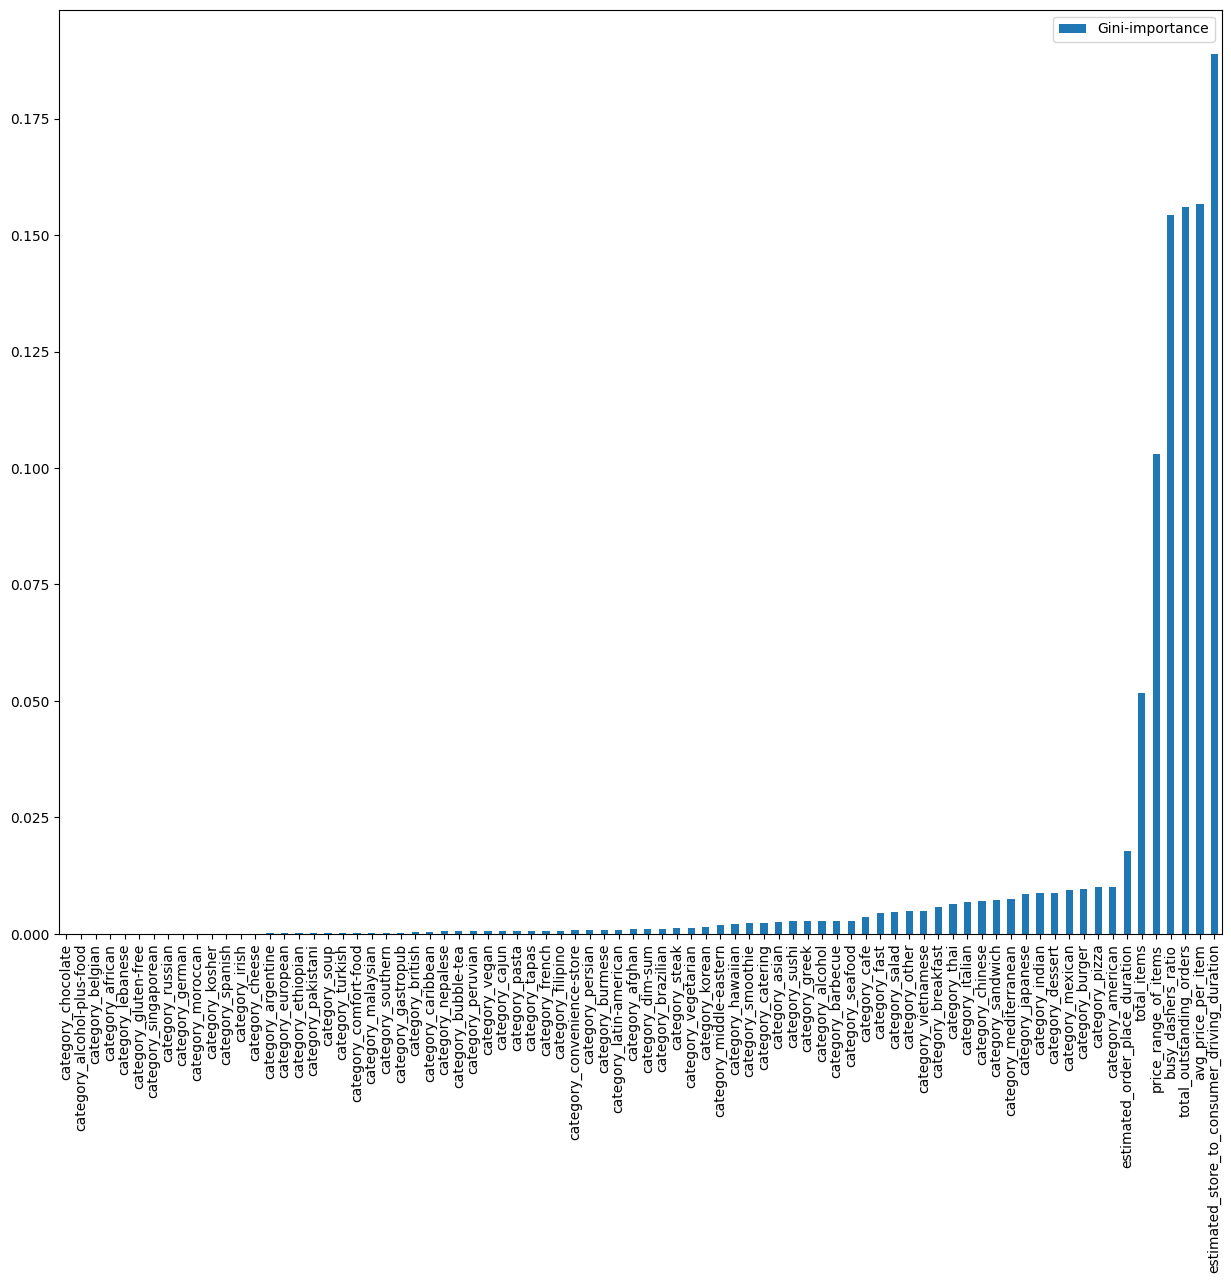

In [45]:
feature_names = [f'feature {i}' for i in range(X.shape[1])] # placeholders for future names
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dictionary to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance # add the name/value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()


Many of the features have a marginal contribution to regression. Let's check the most important ones. 

<Axes: >

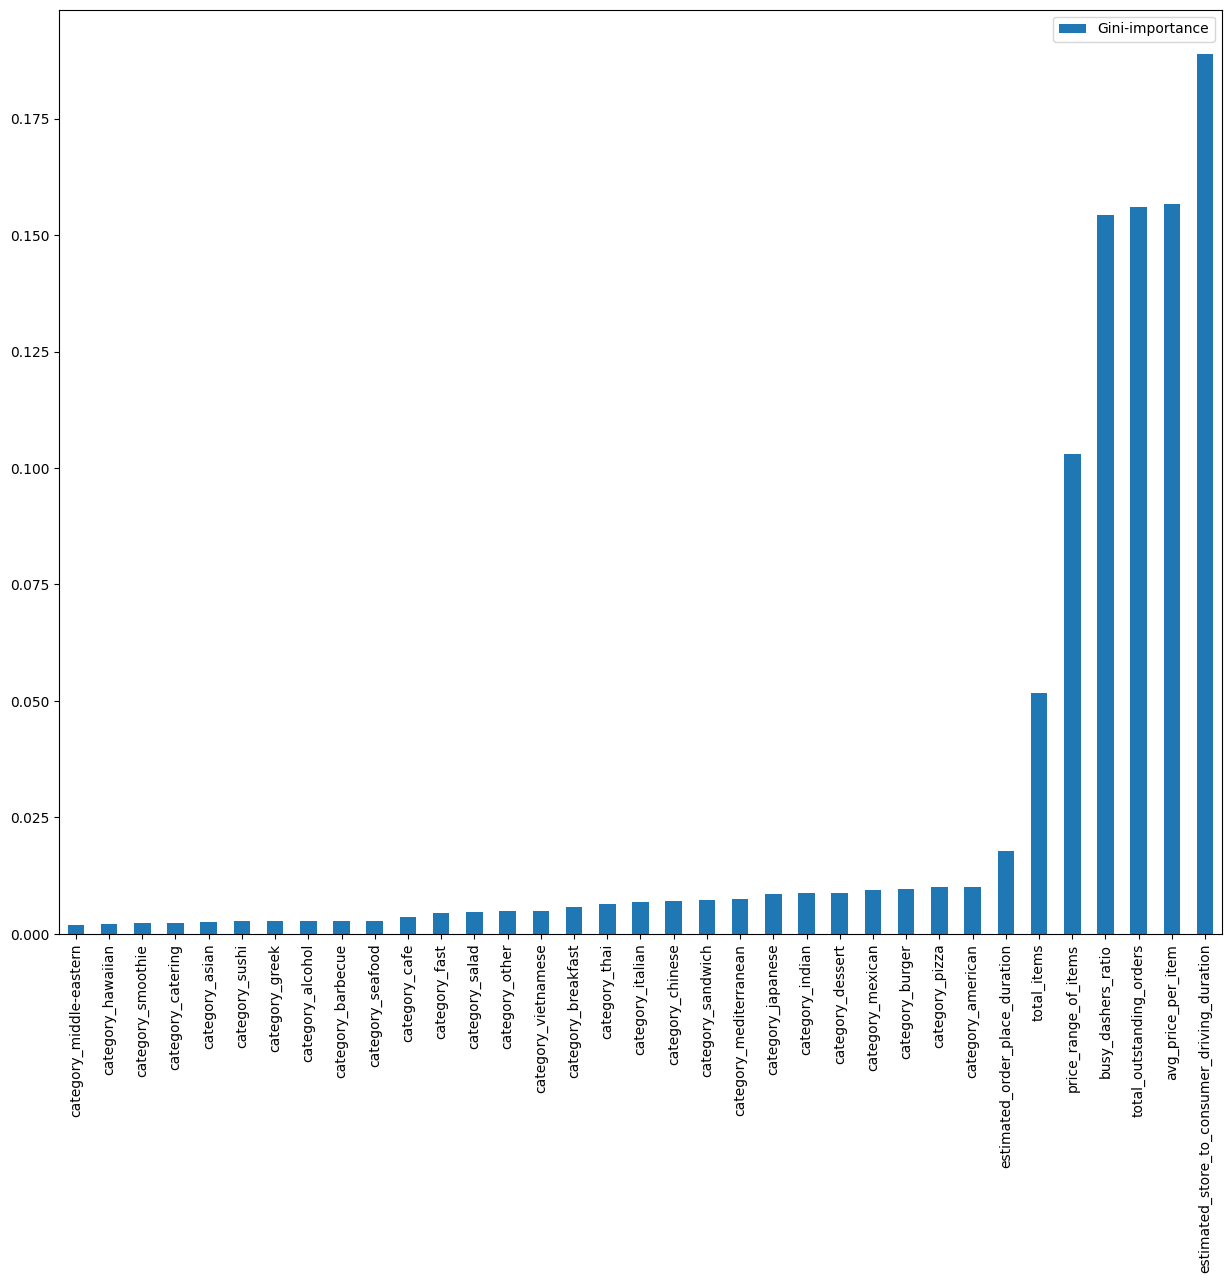

In [46]:
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot = 90 , figsize=(15,12))

As expected, estimated store-to-consumer driving duration is very important to overall delivery duration. Busy dasher ratio, total outstanding orders, and average price per item are also highly contributing features. We select the final features as a subset of these features using these importances.

In [47]:
# obtain the column names of 35 most influential features
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_smoothie',
 'category_catering',
 'category_asian',
 'category_sushi',
 'category_greek',
 'category_alcohol',
 'category_barbecue',
 'category_seafood',
 'category_cafe',
 'category_fast',
 'category_salad',
 'category_other',
 'category_vietnamese',
 'category_breakfast',
 'category_thai',
 'category_italian',
 'category_chinese',
 'category_sandwich',
 'category_mediterranean',
 'category_japanese',
 'category_indian',
 'category_dessert',
 'category_mexican',
 'category_burger',
 'category_pizza',
 'category_american',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

Another method to decrease feature dimension is PCA (Principal Component Analysis). It maps all features to another plane and obtains the most representative interpretations to explain variances in the target variable

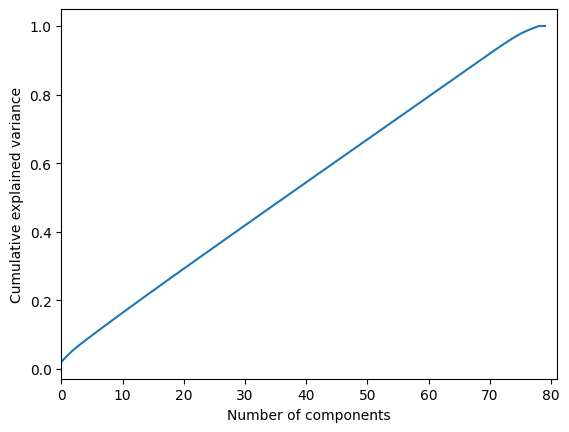

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train = X_train.values
X_Train = np.asarray(X_Train)

# finding the normalized array of X_train
X_std = StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 81)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()        

PCA shows that we need to use at least 60 representative features to explain 80% of the dataset, which makes the PCA transformation useless since we already have 80 and could select the most important ones based on feature importance. However, if PCA would tell us it can explain the majority of the variance with around 10 features - high reduction - we could continue with it.

### Apply Scaler

In [49]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    '''Apply the scaler to features and target variables'''
    X_scaler = scaler.__class__()
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler.__class__()
    y_scaler.fit(y.values.reshape(-1,1))
    y_scaled = y_scaler.transform(y.values.reshape(-1,1))

    return X_scaled, y_scaled, X_scaler, y_scaler

In [50]:
# example to show how to use it
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [51]:
# train-test split after scaling
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size = 0.2, random_state=42)

### Inverse Transform for Metric Comparison

Since we applied a scaler to training data, the predictions for test data will also be scaled. And to see the error in terms of seconds, we need to apply the inverse transformation. We will use Root Mean Squared Error (RMSE) to measure error. We could also use Mean Squared Error or Mean Absolute Error. We gave our decision based on the sensitivity of RMSE for high error terms. In our thought, the consumer patience with delaying delivery could decrease exponentially with more time passing.

In [69]:
from sklearn.metrics import root_mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name, verbose=False):
    '''Convert the scaled error to actual error'''
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    # return RMSE with squared False
    rmse_error = root_mean_squared_error(y_test, y_predict[:,0])
    if verbose:
        print("Error ="'{}'.format(rmse_error)+ ' in '+ model_name)
    return rmse_error, y_predict

### Classical Machine Learning

In [53]:

# creating a function that can work with multiple machine learning models
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose =True):
    '''Apply selected regression model to data and measure error'''
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    train_error = root_mean_squared_error(y_train, y_predict)
    y_predict = model.predict(X_test)
    test_error = root_mean_squared_error(y_test, y_predict)
    if verbose:
        print('Train error: ''{}'.format(train_error)+ ' in '+model_name)
        print('Test error: ''{}'.format(test_error)+ ' in '+model_name)
    trained_model= model
    return trained_model, y_predict, train_error, test_error

In [54]:

from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

pred_dict = {
    'regression_model': [], 
    'feature_set': [],
    'scaler_name': [],
    'RMSE': []
}

regression_models = {
    'Ridge': linear_model.Ridge(), 
    'DecisionTree': tree.DecisionTreeRegressor(max_depth=6), 
    'RandomForest': RandomForestRegressor(),
}

feature_sets = {
    'full_dataset' : X.columns.to_list(),
    'selected_features_40': importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    'selected_features_20': importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    'selected_features_10': importances.sort_values(by= 'Gini-importance')[-10:].index.tolist(),

}

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'NotScale': None,
}

# examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set= feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f'----- scaled with {scaler_name}------ included columns are {feature_set_name}')
        print('')
        for model_name in regression_models.keys():
            if scaler_name == 'NotScale':
                X = train_df[feature_set]
                y = train_df['total_delivery_time']
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            else:
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:, 0], X_test_scaled, y_test_scaled[:, 0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict['regression_model'].append(model_name)
            pred_dict['feature_set'].append(feature_set_name)
            pred_dict['scaler_name'].append(scaler_name)
            pred_dict['RMSE'].append(rmse_error)







----- scaled with StandardScaler------ included columns are full_dataset

Error =2054.001953125 in Ridge
Error =2056.9440590806134 in DecisionTree
Error =2049.553590296024 in RandomForest
----- scaled with MinMaxScaler------ included columns are full_dataset

Error =2054.27490234375 in Ridge
Error =2056.944058961558 in DecisionTree
Error =2048.2802181671755 in RandomForest
----- scaled with NotScale------ included columns are full_dataset



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.80887e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error: 1072.177490234375 in Ridge
Test error: 2053.99755859375 in Ridge
Train error: 1067.7803913412524 in DecisionTree
Test error: 2056.944058809934 in DecisionTree
Train error: 400.79720573311977 in RandomForest
Test error: 2049.3001054618094 in RandomForest
----- scaled with StandardScaler------ included columns are selected_features_40

Error =2054.240966796875 in Ridge
Error =2056.52957908848 in DecisionTree
Error =2046.7441645281847 in RandomForest
----- scaled with MinMaxScaler------ included columns are selected_features_40

Error =2054.51904296875 in Ridge
Error =2056.5295789829997 in DecisionTree
Error =2049.6883353371145 in RandomForest
----- scaled with NotScale------ included columns are selected_features_40

Train error: 1072.890625 in Ridge
Test error: 2054.240966796875 in Ridge


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.02662e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error: 1067.7844258816551 in DecisionTree
Test error: 2056.5295788434096 in DecisionTree
Train error: 401.4729952945981 in RandomForest
Test error: 2049.961375553808 in RandomForest
----- scaled with StandardScaler------ included columns are selected_features_20

Error =2055.386962890625 in Ridge
Error =2054.6131909889255 in DecisionTree
Error =2047.2552833700906 in RandomForest
----- scaled with MinMaxScaler------ included columns are selected_features_20

Error =2055.67822265625 in Ridge
Error =2054.613191050864 in DecisionTree
Error =2049.308267876293 in RandomForest
----- scaled with NotScale------ included columns are selected_features_20

Train error: 1074.732177734375 in Ridge
Test error: 2055.386962890625 in Ridge


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.40829e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error: 1069.133930078849 in DecisionTree
Test error: 2054.6131909522564 in DecisionTree
Train error: 400.75902969196636 in RandomForest
Test error: 2049.3874939687694 in RandomForest
----- scaled with StandardScaler------ included columns are selected_features_10

Error =2056.5146484375 in Ridge
Error =2054.5916819062913 in DecisionTree
Error =2050.748166439006 in RandomForest
----- scaled with MinMaxScaler------ included columns are selected_features_10

Error =2056.82861328125 in Ridge
Error =2054.591681966465 in DecisionTree
Error =2051.67339259038 in RandomForest
----- scaled with NotScale------ included columns are selected_features_10

Train error: 1076.8123779296875 in Ridge
Test error: 2056.5146484375 in Ridge
Train error: 1069.2489778582208 in DecisionTree
Test error: 2054.591681870166 in DecisionTree
Train error: 400.0770531757634 in RandomForest
Test error: 2051.098451595695 in RandomForest


In [55]:
pred_df = pd.DataFrame(pred_dict)

In [56]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full_dataset,StandardScaler,2054.001953
1,DecisionTree,full_dataset,StandardScaler,2056.944059
2,RandomForest,full_dataset,StandardScaler,2049.553590
3,Ridge,full_dataset,MinMaxScaler,2054.274902
4,DecisionTree,full_dataset,MinMaxScaler,2056.944059
5,RandomForest,full_dataset,MinMaxScaler,2048.280218
6,Ridge,full_dataset,NotScale,2048.280218
7,DecisionTree,full_dataset,NotScale,2048.280218
8,RandomForest,full_dataset,NotScale,2048.280218
9,Ridge,selected_features_40,StandardScaler,2054.240967


<Axes: >

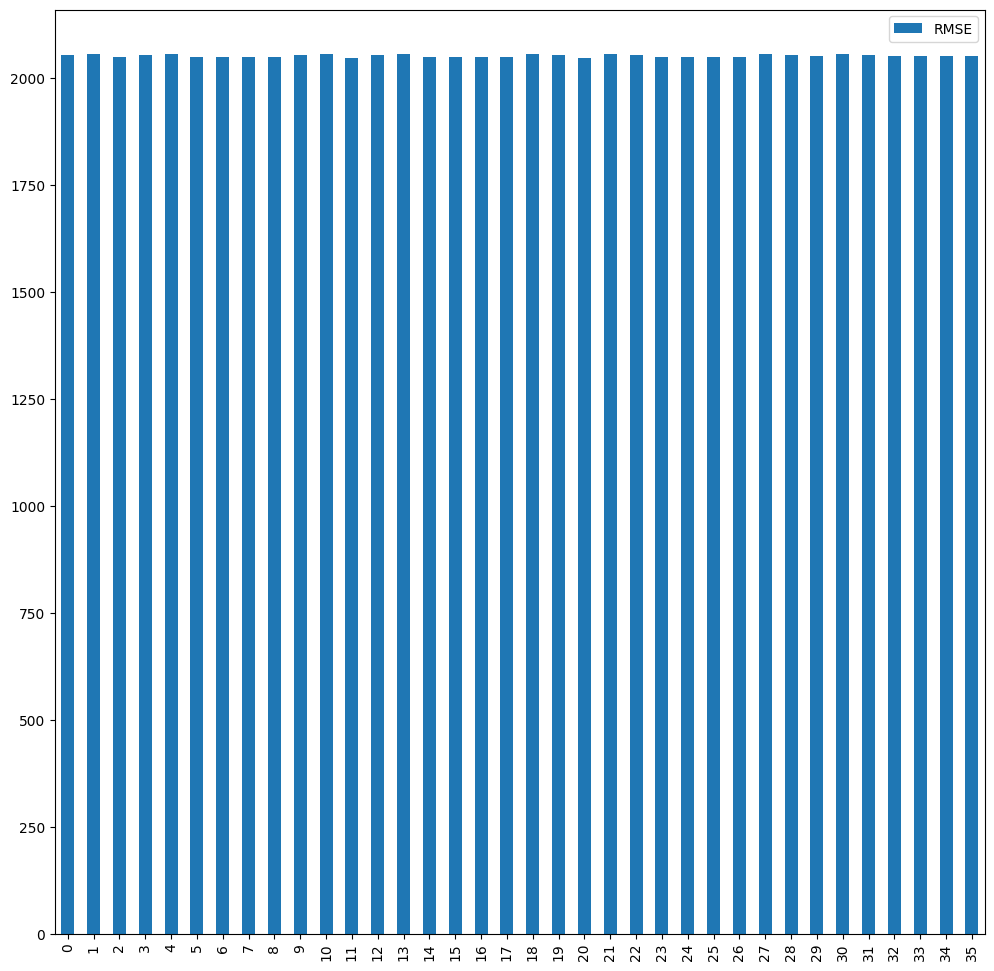

In [57]:
pred_df.plot(kind='bar', figsize=(12,12))


It seems we have high errors through all models. Also, not scaling appears to have no effect on the end result. However, we still pick a scaler and continue. The decrease in training feature size intially slightly improves the performance but as the set got smaller, the performance got marginally worse. So we choose the second feature set with 40 features. High error rates through all models is very concerning. Could it be that the dataset is not a good representative for estimating the total delivery duration? Another idea could to reformulate the question and solve for preparation time instead and later sum it up with non-prep time to come up with the total delivery duration. 

In [58]:
# change the problem
train_df['prep_time'] = train_df['total_delivery_time'] - train_df['estimated_store_to_consumer_driving_duration'] - train_df['estimated_order_place_duration']

scalers = {
    'StandardScaler': StandardScaler(),
}

feature_sets = {
    'selected_features_40': importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"---- scaled with {scaler_name}----- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
           # X = train_df[feature_set].drop(columns=['estimated_store_to_condumer_driving_duration', 'estimated_order_place_duration'])
           y = train_df['prep_time']

           X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
           train_indices = X_train.index
           test_indices = X_test.index

           X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

           X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size = 0.2, random_state=42)
           _, y_predict_scaled, _, _ = make_regression(X_train_scaled,y_train_scaled[:, 0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
           rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
           pred_dict['regression_model'].append(model_name)
           pred_dict['feature_set'].append(feature_set_name)
           pred_dict['scaler_name'].append(scaler_name)
           pred_dict['RMSE'].append(rmse_error)



           

---- scaled with StandardScaler----- included columns are selected_features_40

Error =2056.5146484375 in Ridge
Error =2045.9432788528268 in DecisionTree
Error =2047.8967032981138 in RandomForest


In [60]:
# choose the best performing model and extract the predictions for the preparation duration
pred_values_dict = {
    'total_delivery_time' : train_df['total_delivery_time'][test_indices].values.tolist(),
    'prep_duration_prediction' : y_predict[:, 0].tolist(),
    'estimated_store_to_consumer_driving_duration' : train_df['estimated_store_to_consumer_driving_duration'][test_indices].values.tolist(),
    'estimated_order_place_duration' : train_df['estimated_order_place_duration'][test_indices].values.tolist(),
}

In [62]:
# convert it to a dataframe from a dictionary

values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,total_delivery_time,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1433.810001,380.0,251.0
1,1839.0,1620.200006,747.0,446.0
2,1927.0,2186.549993,543.0,251.0
3,2657.0,1433.939996,445.0,251.0
4,3596.0,1854.090001,691.0,446.0
...,...,...,...,...
35409,9557.0,2821.100006,768.0,446.0
35410,1864.0,1910.460002,324.0,446.0
35411,2674.0,1634.969995,791.0,251.0
35412,2234.0,1676.920008,687.0,251.0


In [64]:
values_df['sum_total_delivery_duration'] = values_df['prep_duration_prediction'] + values_df['estimated_store_to_consumer_driving_duration'] + values_df['estimated_order_place_duration']
values_df

,total_delivery_time,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1433.810001,380.0,251.0,2064.810001
1,1839.0,1620.200006,747.0,446.0,2813.200006
2,1927.0,2186.549993,543.0,251.0,2980.549993
3,2657.0,1433.939996,445.0,251.0,2129.939996
4,3596.0,1854.090001,691.0,446.0,2991.090001
...,...,...,...,...,...
35409,9557.0,2821.100006,768.0,446.0,4035.100006
35410,1864.0,1910.460002,324.0,446.0,2680.460002
35411,2674.0,1634.969995,791.0,251.0,2676.969995
35412,2234.0,1676.920008,687.0,251.0,2614.920008


In [65]:
# check new error rate
root_mean_squared_error(values_df['total_delivery_time'], values_df['sum_total_delivery_duration'])

2047.8967032981138

In [66]:
# Use another regression to obtain the actual total delivery duration
X = values_df[['prep_duration_prediction', 'estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration']]
y = values_df[['total_delivery_time']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)


In [67]:
regression_models = {
    'LinearReg' : linear_model.LinearRegression(),
    'Ridge': linear_model.Ridge(),
    'DecisionTree': tree.DecisionTreeRegressor(max_depth=6),
    'RandomForest': RandomForestRegressor()
}

for model_name in regression_models.keys():
    _, y_predict, _, _ = make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=False)
    print(f'RMSE of {model_name}: {root_mean_squared_error(y_test,y_predict)}')
    

RMSE of LinearReg: 1002.4540923861273
RMSE of Ridge: 1002.4540923866621
RMSE of DecisionTree: 1017.27855034855


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE of RandomForest: 1540.7516465188194


Would scaling the inputs reduce the RMSE? Next we try to scale the input features and look at the difference. 


In [72]:
scalers = {
    'StandardScaler' : StandardScaler(),
    'MinMaxScaler' : MinMaxScaler(),
}

for scaler_name in scalers.keys():
    print(f'\n{scaler_name}')
    X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
    for model_name in regression_models.keys():
        _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:, 0], regression_models[model_name], model_name, verbose=False)
        _, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
        print(f'RMSE of {model_name} with {scaler_name} applied : {root_mean_squared_error(y_test, y_predict)}')




StandardScaler
RMSE of LinearReg with StandardScaler applied : 1002.4540923861274
RMSE of Ridge with StandardScaler applied : 1002.4536734554272
RMSE of DecisionTree with StandardScaler applied : 1017.27855034855
RMSE of RandomForest with StandardScaler applied : 1365.5468100383032

MinMaxScaler
RMSE of LinearReg with MinMaxScaler applied : 1002.4540923861271
RMSE of Ridge with MinMaxScaler applied : 1002.3240327151434
RMSE of DecisionTree with MinMaxScaler applied : 1017.27855034855
RMSE of RandomForest with MinMaxScaler applied : 1227.2301818580995


The best performance comes from applying the MinMaxScaler and training the Ridge Regression algorithm, so we accept this as our official solution. Note that the predictions on our best solution is still off by around 16 minutes on average which means there is a lot of room for improvement in the current solution. 